In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch

from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe import YOLOEVPSegPredictor, YOLOEVPDetectPredictor


In [ ]:
# Initialize a YOLOE segmentation model
model = YOLOE("yoloe-11s-seg.pt")

In [ ]:
# --- Step 1: Define prompts for reference images ---
# Prompts for the first reference image
visual_prompts_1 = dict(
    bboxes=np.array(
        [
            [215, 392, 350, 864],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

# Prompts for a second reference image (using bus.jpg again for simplicity)
visual_prompts_2 = dict(
    bboxes=np.array(
        [
            [41, 391, 246, 905],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

# # Prompts for a second reference image (using bus.jpg again for simplicity)
visual_prompts_3 = dict(
    bboxes=np.array(
        [
            [1, 535, 82, 879],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

# Prompts for a second reference image (using bus.jpg again for simplicity)
visual_prompts_4 = dict(
    bboxes=np.array(
        [
            [666, 385, 807, 875],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

In [7]:
# --- Step 2: Manually create a predictor instance ---
results = model.predict(
    "bus.jpg",
    visual_prompts=visual_prompts_1,
    predictor=YOLOEVPDetectPredictor,
)

results[0].show()

Ultralytics 8.3.175  Python-3.10.18 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24564MiB)
YOLOe-11s-seg summary (fused): 137 layers, 13,693,398 parameters, 1,857,958 gradients

image 1/1 c:\Users\jordan\Documents\GitHub\CoralNet-Toolbox\notebooks\bus.jpg: 640x480 3 object0s, 77.6ms
Speed: 2.5ms preprocess, 77.6ms inference, 996.0ms postprocess per image at shape (1, 3, 640, 480)


In [8]:

# --- Step 3: Generate and collect VPEs from reference images ---
vpe_list = []
print("Generating VPEs from reference images...")

# Generate VPE for the first image
model.predictor.set_prompts(visual_prompts_1)
vpe1 = model.predictor.get_vpe("bus.jpg")
vpe_list.append(vpe1)
print("Generated VPE from the first prompt.")

# Generate VPE for the second image
model.predictor.set_prompts(visual_prompts_2)
vpe2 = model.predictor.get_vpe("bus.jpg")
vpe_list.append(vpe2)
print("Generated VPE from the second prompt.")

# # Generate VPE for the third image
model.predictor.set_prompts(visual_prompts_3)
vpe3 = model.predictor.get_vpe("bus.jpg")
vpe_list.append(vpe3)
print("Generated VPE from the third prompt.")

# Generate VPE for the fourth image
model.predictor.set_prompts(visual_prompts_4)  
vpe4 = model.predictor.get_vpe("bus.jpg")
vpe_list.append(vpe4)
print("Generated VPE from the fourth prompt.")


Generating VPEs from reference images...
Generated VPE from the first prompt.
Generated VPE from the second prompt.
Generated VPE from the third prompt.
Generated VPE from the fourth prompt.


In [9]:
# --- Step 4: Aggregate the VPEs ---
# Combine the list of VPE tensors and average them
final_vpe = torch.cat(vpe_list).mean(dim=0, keepdim=True)

# Normalize the final embedding
final_vpe = torch.nn.functional.normalize(final_vpe, p=2, dim=-1)
print("\nSuccessfully combined VPEs into a single, normalized embedding.")


Successfully combined VPEs into a single, normalized embedding.


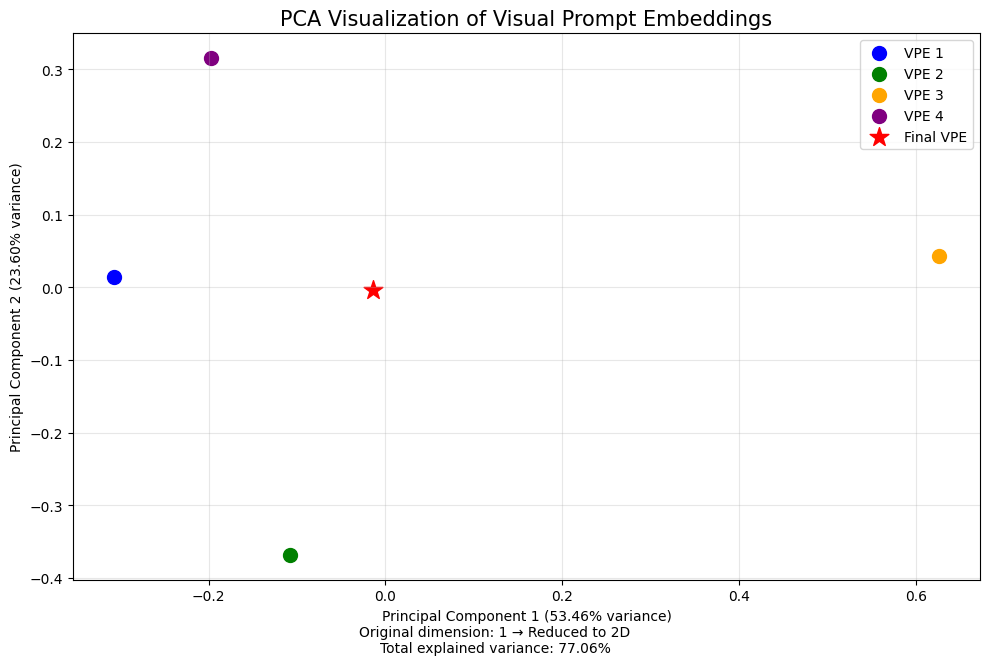

In [ ]:
# --- Step 5: Visualize VPEs using PCA ---

# Convert tensors to numpy arrays for PCA
vpe_arrays = [vpe.detach().cpu().numpy().squeeze() for vpe in vpe_list]
final_vpe_array = final_vpe.detach().cpu().numpy().squeeze()

# Stack all embeddings for PCA
all_vpes = np.vstack(vpe_arrays + [final_vpe_array])

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
vpes_2d = pca.fit_transform(all_vpes)

# Create a simple scatter plot
plt.figure(figsize=(10, 7))

# Plot individual VPEs
plt.scatter(vpes_2d[0, 0], vpes_2d[0, 1], color='blue', s=100, label='VPE 1')
plt.scatter(vpes_2d[1, 0], vpes_2d[1, 1], color='green', s=100, label='VPE 2')
plt.scatter(vpes_2d[2, 0], vpes_2d[2, 1], color='orange', s=100, label='VPE 3')
plt.scatter(vpes_2d[3, 0], vpes_2d[3, 1], color='purple', s=100, label='VPE 4')

# Plot the final (averaged) VPE
plt.scatter(vpes_2d[4, 0], vpes_2d[4, 1], color='red', s=200, marker='*', label='Final VPE')

# Add labels and information
plt.title('PCA Visualization of Visual Prompt Embeddings', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(alpha=0.3)
plt.legend()

# Add a text annotation with information about the original dimensionality
orig_dim = vpe_list[0].shape[1]
plt.figtext(0.5, 0.01, 
            f"Original dimension: {orig_dim} → Reduced to 2D\n"
            f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}",
            ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the text
plt.show()

In [ ]:
# --- Step 6: Run inference using the aggregated VPE ---

# Directly set the final tensor as the prompt for the predictor.
# The `inference` method is designed to use this tensor.
model.is_fused = lambda: False
model.set_classes(["person"], final_vpe)

In [19]:
results = model.predict("zidane.jpg")

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()


image 1/1 c:\Users\jordan\Documents\GitHub\CoralNet-Toolbox\notebooks\zidane.jpg: 384x640 1 person, 72.8ms
Speed: 1.5ms preprocess, 72.8ms inference, 33.2ms postprocess per image at shape (1, 3, 384, 640)
Inference complete. Results are generated.


In [20]:
results = model.predict("bus.jpg")

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()



image 1/1 c:\Users\jordan\Documents\GitHub\CoralNet-Toolbox\notebooks\bus.jpg: 640x480 5 persons, 10.7ms
Speed: 2.8ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)
Inference complete. Results are generated.


In [21]:
results = model.predict("people_1.jpg")

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()



image 1/1 c:\Users\jordan\Documents\GitHub\CoralNet-Toolbox\notebooks\people_1.jpg: 448x640 5 persons, 71.4ms
Speed: 2.2ms preprocess, 71.4ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)
Inference complete. Results are generated.


### Exporting Final VPEs and Re-importing

In [22]:
final_vpe

tensor([[[-9.6949e-03,  2.1620e-02,  2.7101e-02, -5.8837e-02,  9.2145e-03, -1.4030e-02,  2.8804e-02, -9.6638e-03, -6.8302e-03, -1.1863e-01,  1.0181e-01, -5.4819e-02, -1.1983e-01,  1.5630e-03, -1.8654e-02, -1.1144e-02,  4.7958e-02, -6.2789e-03, -4.3141e-03,  1.2277e-02,  2.9385e-02, -1.4775e-03,  5.8635e-02,
           4.2288e-02,  4.7035e-02,  1.1830e-03, -8.6836e-03,  9.5640e-02, -1.3936e-02, -9.1632e-04, -1.5387e-03, -5.3074e-02,  5.8432e-03, -2.1165e-02,  5.9366e-02,  2.9493e-02, -4.7558e-02,  4.9393e-02, -2.9484e-02, -1.6430e-02,  1.8850e-02,  2.9378e-02,  5.5461e-02, -1.1259e-02,  9.7095e-03,  3.1146e-02,
          -2.2103e-02, -6.3676e-02,  1.1724e-04,  7.8209e-02, -1.1272e-01,  1.4118e-02,  2.5256e-03, -2.1628e-02,  1.1564e-02, -4.1129e-02,  8.8067e-02, -2.4590e-02, -2.0162e-04, -2.8201e-02,  2.2250e-03, -3.3310e-02, -6.0551e-02, -3.6556e-02, -2.5412e-02, -3.8527e-02,  2.4195e-02,  2.4724e-02, -5.5092e-02,
          -2.6341e-02,  4.3778e-02,  1.3742e-02,  1.5956e-02,  1.4899e-02

In [23]:
# Export the final_vpe tensor to disk

# Move to CPU before saving to ensure compatibility when loading
final_vpe_cpu = final_vpe.cpu()

# Save the tensor
torch.save(final_vpe_cpu, "vpe.pt")
print(f"Saved VPE tensor to person_vpe.pt")

Saved VPE tensor to person_vpe.pt


In [ ]:
# Re-import the VPE tensor
loaded_vpe = torch.load("vpe.pt")

# Move to the appropriate device if needed (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_vpe = loaded_vpe.to(device)

print(f"Loaded VPE tensor from disk. Shape: {loaded_vpe.shape}")
print(f"Device: {loaded_vpe.device}")

Loaded VPE tensor from disk. Shape: torch.Size([1, 1, 512])
Device: cuda:0
Successfully verified: loaded VPE matches the original


In [44]:
# Initialize a YOLOE segmentation model
model_2 = None
model_2 = YOLOE("yoloe-11s-seg.pt")

In [45]:
# Prompts for the first reference image
visual_prompts_1 = dict(
    bboxes=np.array(
        [
            [215, 392, 350, 864],  # Box enclosing person
        ],
    ),
    cls=np.array(
        [
            0,  # ID to be assigned for person
        ]
    ),
)

In [49]:
results = model_2.predict(
    "bus.jpg",
    visual_prompts=visual_prompts_1,
    predictor=YOLOEVPDetectPredictor,
)

results[0].show()

Ultralytics 8.3.175  Python-3.10.18 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24564MiB)

image 1/1 c:\Users\jordan\Documents\GitHub\CoralNet-Toolbox\notebooks\bus.jpg: 640x480 3 object0s, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


In [47]:
# --- Step 6: Run inference using the aggregated VPE ---

# Directly set the final tensor as the prompt for the predictor.
# The `inference` method is designed to use this tensor.
model_2.is_fused = lambda: False
model_2.set_classes(["person"], loaded_vpe)

In [48]:
results = model_2.predict("bus.jpg",
                        #   visual_prompts=visual_prompts_1,
                          predictor=YOLOEVPDetectPredictor,  # Okay to keep
                          )

print("Inference complete. Results are generated.")
# You can now process or display the 'results'.
results[0].show()



image 1/1 c:\Users\jordan\Documents\GitHub\CoralNet-Toolbox\notebooks\bus.jpg: 640x480 5 persons, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)
Inference complete. Results are generated.
